# Discretization and clustering

We'll discretize trajectories using the [H3 library](https://uber.github.io/h3-py/intro.html) and then use a metric that is designed to compare discrete sequences (like strings) in the clustering.

## Get data

We'll download one file from https://zenodo.org/record/4650317.
This only needs to be executed once.

In [1]:
# !mkdir -p data/
# !curl \
#     -o data/trajectories_nostokes_subset_10000.csv.gz \
#     https://zenodo.org/record/4650317/files/trajectories_nostokes_subset_10000.csv.gz
# !gunzip -f -v data/trajectories_nostokes_subset_10000.csv.gz

## Prepare env

In [2]:
import numpy as np
import pandas as pd

## Parameters

In [3]:
num_traj = 500
random_trajs = True
random_seed = 1234
data_path = "data/trajectories_nostokes_subset_10000.csv"

In [4]:
np.random.seed(random_seed)  # reproducibility!

## Load data and extract a few trajectories

In [5]:
def load_and_subset_trajectories(
    file_name, num_traj=300, use_random=False
):
    """Load data file and extract a number of trajectories.
    
    Parameters
    ----------
    file_name: str or Path
        File to open.
    num_traj: int
        Number of trajectories to load
    use_random: book
        If true, choose num_traj trajectories at random.
        If false, choose first num_traj trajectories.
    
    Returns
    -------
    pandas.DataFrame
        Trajectorie

    """

    df = pd.read_csv(file_name)

    # the whole dataset is too big to open here.
    if use_random:
        # Let's subset to fewer random trajectories:
        random_trajs = np.random.choice(
            np.unique(df["traj"]), num_traj, replace=False
        )
        traj_mask = df["traj"].apply(lambda x: x in random_trajs)
    else:
        # Let's use the first N trajectories
        first_n_trajs = np.unique(df["traj"])[:num_traj]
        traj_mask = df["traj"].apply(lambda x: x in first_n_trajs)
    
    df = df[traj_mask]
    
    return df

In [6]:
df = load_and_subset_trajectories(
    data_path,
    num_traj=num_traj,
    use_random=random_trajs,
)

df["time"] = pd.to_datetime(df["time"])

# df = df[["traj", "obs", "lat", "lon"]]

df = df.set_index(["traj", "obs"])

df = df.sort_index(axis=0, level=0)

display(df)

MPA    distance  land        lat       lon       temp  \
traj  obs                                                          
14    0    1.0    0.000000   0.0  43.273212  5.217502  18.389540   
      1    1.0    0.057068   0.0  43.273440  5.216870  18.392120   
      2    1.0    0.114757   0.0  43.273670  5.216229  18.394533   
      3    1.0    0.173070   0.0  43.273900  5.215579  18.396700   
      4    1.0    0.232007   0.0  43.274128  5.214921  18.398626   
...        ...         ...   ...        ...       ...        ...   
10002 957  0.0  372.354160   0.0  37.227657 -1.212568  26.270330   
      958  0.0  372.764530   0.0  37.224224 -1.214291  26.278946   
      959  0.0  373.180200   0.0  37.220745 -1.216031  26.287903   
      960  0.0  373.598420   0.0  37.217247 -1.217788  26.297262   
      961  0.0  373.633500   0.0  37.216953 -1.217935  26.298060   

                         time         z  
traj  obs                                
14    0   2017-06-03 00:00:00  7.920377  
      1   2017-06-03 01:00:00  7.920377  
      2   2017-06-03 02:00:00  7.920377  
      3   2017-06-03 03:00:00  7.920377  
      4   2017-06-03 04:00:00  7.920377  
...                       ...       ...  
10002 957 2017-07-25 21:00:00  7.920377  
      958 2017-07-25 22:00:00  7.920377  
      959 2017-07-25 23:00:00  7.920377  
      960 2017-07-26 00:00:00  7.920377  
      961 2017-07-26 00:00:00  7.920377  

[481000 rows x 8 columns]

## Have a look

<AxesSubplot:xlabel='lon', ylabel='lat'>

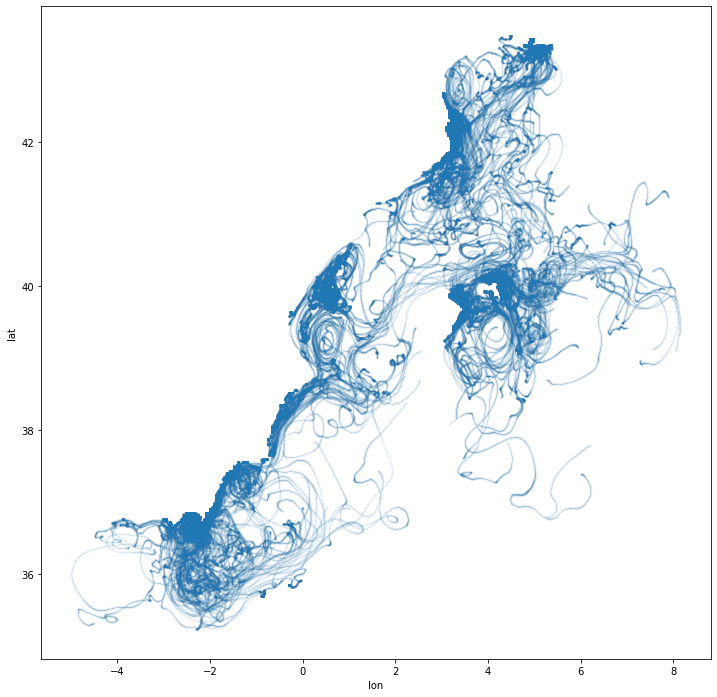

In [7]:
df.plot.scatter(x="lon", y="lat", s=1, alpha=0.05, figsize=(12, 12))

## Discretize with H3

In [8]:
import h3
import h3.api.numpy_int
import h3.api.basic_str

In [9]:
def df_to_h3(df, resolution=0):
    """Convert series of lat and lon to series of h3s.
    
    Parameters
    ----------
    df: pandas.Dataframe
        Has columns "lat" and "lon".
    resolution: int
        H3 resolution. Default to 8 corresponding to approx. 500 meters.
        
    Returns
    -------
    pandas.Series
        h3s
    """
    return df.apply(
        lambda rw: h3.geo_to_h3(
            lat=rw["lat"], lng=rw["lon"],
            resolution=resolution,
        ),
        axis=1,
    ).to_frame(name="h3")

In [10]:
%%time

df["h3"] = df_to_h3(df)

CPU times: user 6.06 s, sys: 132 ms, total: 6.19 s
Wall time: 6.19 s


In [11]:
def _get_unique_index(trajectory):
    def _collapse(sequence):
        last = None
        for n, element in enumerate(sequence):
            if element != last:
                yield n
            last = element
    return trajectory.index[list(_collapse(trajectory))]

In [12]:
def _collapse_h3_traj(traj):
    collapsed_ind = _get_unique_index(traj["h3"])
    return traj.loc[collapsed_ind]

In [13]:
def collapse_h3s_df(df):
    """Collapse identical consecutive H3s in each trajectory in df.
    
    Parameters
    ----------
    df: pandas.DataFrame
        Input dataframe having a `MultiIndex` ('traj', 'obs').
    
    Returns
    -------
    pandas.DataFrame
        With the same trajectory index, but collapsed `obs` steps.
    
    """
    traj_dfs = (_df for _traj, _df in df.groupby("traj"))
    collapsed_traj_dfs = map(_collapse_h3_traj, traj_dfs)
    return pd.concat(collapsed_traj_dfs)

In [14]:
%time display(collapse_h3s_df(df_to_h3(df, resolution=6)))

h3
traj  obs                 
14    0    86396811fffffff
      14   863968117ffffff
      60   863968107ffffff
      68   86396811fffffff
      96   863968037ffffff
...                    ...
10002 877  8638250e7ffffff
      878  8638250c7ffffff
      917  8638250dfffffff
      936  86382572fffffff
      954  863825707ffffff

[30486 rows x 1 columns]

CPU times: user 6.5 s, sys: 80 ms, total: 6.58 s
Wall time: 6.58 s


## Remove very short trajectories

In [15]:
def remove_short_trajs(df, cutoff=0):
    """Remove short trajectories at the given resolution.
    
    Parameters
    ----------
    df: pandas.DataFrame
        First index level counts trajectories.
    cutoff: int
        Defaults to 0, meaning no trajectories will be discarded.
        
    Returns
    -------
    pandas.DataFrame
        Contains only long trajectories.

    """
    number_points = pd.Series(
        [len(df.loc[traj]) for traj in df.index.levels[0]],
        index=df.index.levels[0]
    )

    long_trajectories = number_points.index[(number_points >= cutoff)]
    
    if len(long_trajectories) > 0:
        df_ret = pd.concat(
            (df.loc[trj] for trj in long_trajectories),
            keys=long_trajectories
        )
    else:  # return empty if no traj remains
        df_ret = pd.DataFrame(data=None, columns=df.columns, index=df.index).iloc[:0]
    
    return df_ret

In [16]:
%time remove_short_trajs(collapse_h3s_df(df_to_h3(df, resolution=7)), cutoff=4)

CPU times: user 6.86 s, sys: 95.9 ms, total: 6.95 s
Wall time: 6.95 s


h3
traj  obs                 
14    0    87396811effffff
      18   873968111ffffff
      59   873968102ffffff
      63   87396811cffffff
      78   87396811dffffff
...                    ...
10002 943  873825728ffffff
      948  87382572effffff
      952  87382572affffff
      954  873825705ffffff
      959  873825700ffffff

[77862 rows x 1 columns]

## Distance metric

In [17]:
import editdistance

In [18]:
def traj_editdist(traj_0, traj_1):
    return editdistance.eval(list(traj_0["h3"]), list(traj_1["h3"]))

In [19]:
traj_0_index = df.index.levels[0][0]
traj_1_index = df.index.levels[0][2]

In [20]:
traj0 = df.loc[traj_0_index]
traj1 = df.loc[traj_1_index]

%time traj_editdist(traj0, traj1)

CPU times: user 4.55 ms, sys: 30 µs, total: 4.58 ms
Wall time: 4.4 ms


32

In [21]:
_df = collapse_h3s_df(df)
traj0 = _df.loc[traj_0_index]
traj1 = _df.loc[traj_1_index]

%time traj_editdist(traj0, traj1)

CPU times: user 167 µs, sys: 9 µs, total: 176 µs
Wall time: 182 µs


2

## Clustering

In [22]:
from sklearn.cluster import DBSCAN, OPTICS, KMeans, AgglomerativeClustering
from sklearn.metrics import pairwise_distances

### Data and metric prep

In [23]:
def wrapped_dist(x, y, df=None, **kwargs):
    i, j = int(x[0]), int(y[0])
    tind0 = df.index.levels[0][i]
    tind1 = df.index.levels[0][j]
    t0 = df.loc[tind0]
    t1 = df.loc[tind1]
    norm = max(len(t0), len(t1))
    return traj_editdist(t0, t1) / norm

In [24]:
from functools import partial

In [25]:
def get_edit_distance_matrix(df):
    X = np.arange(len(df.index.levels[0])).reshape(-1, 1)
    return pairwise_distances(X, metric=partial(wrapped_dist, df=df))

### Clustering

In [26]:
%%time

_df = remove_short_trajs(collapse_h3s_df(df_to_h3(df, resolution=3)), cutoff=2)
# _df = _df.reindex()
print(len(_df.index.levels[0]))

387
CPU times: user 6.51 s, sys: 67.9 ms, total: 6.58 s
Wall time: 6.58 s


In [27]:
%%time

dist = get_edit_distance_matrix(_df)

CPU times: user 27.6 s, sys: 570 ms, total: 28.1 s
Wall time: 27.5 s


In [28]:
dist.shape

(387, 387)

In [29]:
import xarray as xr

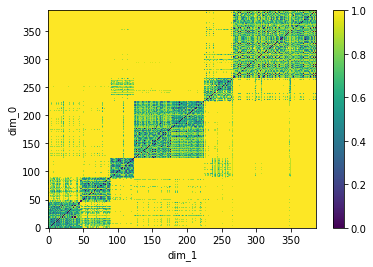

In [30]:
xr.DataArray(dist).plot();

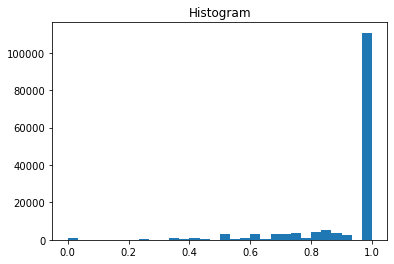

In [31]:
xr.DataArray(dist).plot.hist(bins=30);

In [32]:
%%time
# ids = OPTICS(metric="precomputed", max_eps=0.6).fit_predict(dist)
ids = AgglomerativeClustering(affinity="precomputed", linkage="complete", distance_threshold=0.9, n_clusters=None).fit_predict(dist)
# ids = DBSCAN(metric="precomputed", eps=0.3).fit_predict(dist)

CPU times: user 15.5 ms, sys: 4.17 ms, total: 19.7 ms
Wall time: 16.7 ms


<AxesSubplot:ylabel='Frequency'>

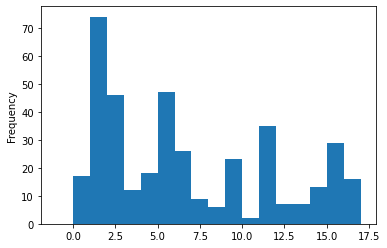

In [33]:
pd.Series(ids).plot.hist(bins=np.arange(-1, ids.max() + 1))

In [34]:
import numpy as np

In [35]:
from matplotlib import pyplot as plt

In [36]:
from shapely.geometry import Polygon

import geopandas

In [37]:
hexs = np.unique(_df["h3"])

In [38]:
polygonise = lambda hex_id: Polygon(
    h3.h3_to_geo_boundary(
        hex_id, geo_json=True)
)

all_polys = geopandas.GeoSeries(
    list(map(polygonise, hexs)), 
    index=hexs, 
    crs="EPSG:4326",    
)

0 0 101
1 1 400
2 2 244
3 3 76
4 4 125
5 5 374
6 6 128
7 7 28
8 8 23
9 9 76
10 10 12
11 11 156
12 12 62
13 13 56
14 14 99
15 15 61
16 16 36
17 17 88


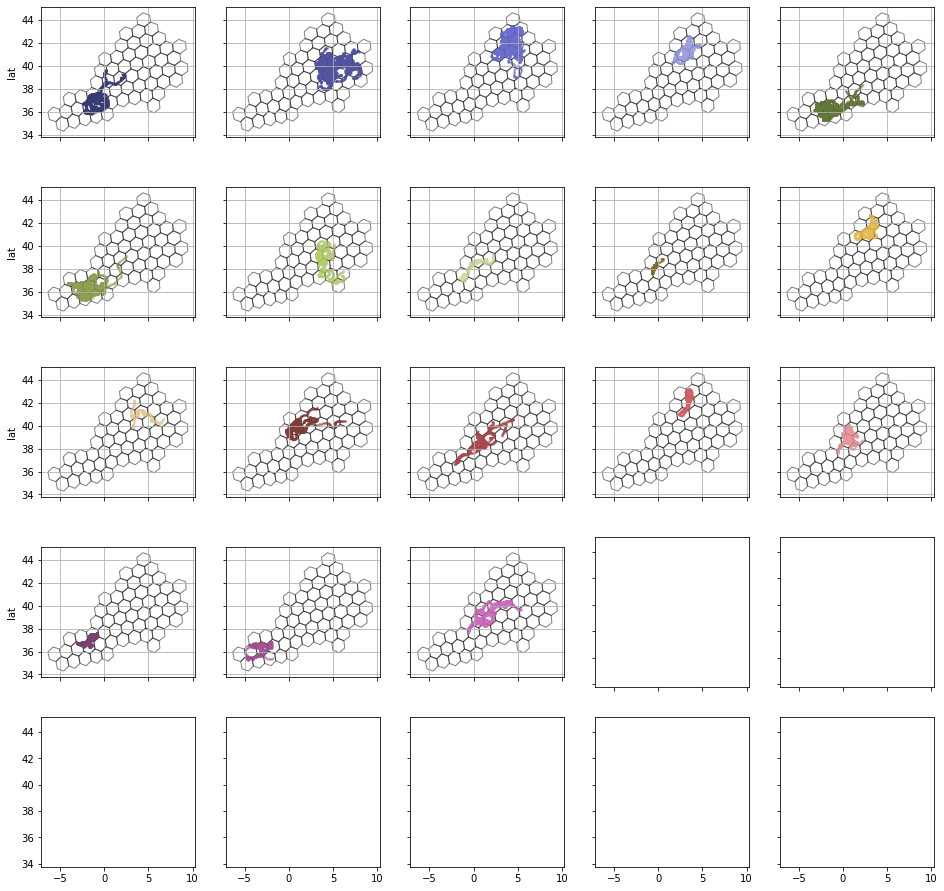

In [39]:
# _df = remove_short_trajs(collapse_h3s_df(df_to_h3(df, resolution=5)), cutoff=10)
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(16, 16))
for (n, _id), _ax in zip(enumerate(np.unique(ids)), ax.flatten()):
    print(n, _id, len(_df.loc[_df.index.levels[0][ids==_id]]))
    _trajs = _df.index.levels[0][ids==_id]
    all_polys.plot(alpha=0.5, color="none", edgecolor='black', figsize=(9, 9), ax=_ax)
    df.loc[_trajs].plot.scatter(x="lon", y="lat", s=2, alpha=0.05, ax=_ax, color=plt.cm.tab20b(n / (ids.max() + 1)))
    _ax.grid();